In [1]:
import os
import sys
import tarfile
import collections
import torch
import torch.utils.data as data
from torchvision.datasets.utils import download_url, check_integrity
from torchvision import datasets
import torchvision as tv
import numpy as np
import matplotlib.pyplot as plt
import argparse
from models import *
from torch.utils.data import DataLoader
from utils.logger import *
from utils.utils import *
from utils.datasets import *
from utils.parse_config import *
from terminaltables import AsciiTable
import datetime
from test import evaluate
from torch.autograd import Variable
from matplotlib.ticker import NullLocator
%matplotlib notebook


In [2]:
def target_transform (target, img_size = (224,224) ):
    
    object_to_idx = {'aeroplane': 0,'bicycle': 1,'bird': 2,'boat': 3,
                  'bottle': 4,'bus': 5,'car': 6,'cat': 7,
                  'chair': 8,'cow': 9,'diningtable': 10,'dog': 11,
                  'horse': 12,'motorbike': 13,'person': 14,'pottedplant': 15,
                  'sheep': 16,'sofa': 17,'train': 18,'tvmonitor': 19}
    
    
    h = target['annotation']['size']['height']
    h = float(h)
    w = target['annotation']['size']['width']
    w = float(w)

    if isinstance(target['annotation']['object'], list):
      boxes = [[object_to_idx[x['name']]] + [x['bndbox']['xmin'],x['bndbox']['ymin'],x['bndbox']['xmax'],x['bndbox']['ymax']] for x in target['annotation']['object']]
    elif isinstance(target['annotation']['object'], dict):
      x = target['annotation']['object']['bndbox']
      boxes = [object_to_idx[target['annotation']['object']['name']]] + [x['xmin'],x['ymin'],x['xmax'],x['ymax']]
    else:
      print('I do not know what happened')
    boxes = np.array(boxes).astype(np.float)
    boxes = boxes.reshape(-1, 5)
    xmin = boxes[:, 1] / w
    ymin = boxes[:, 2] / h
    xmax = boxes[:, 3] / w
    ymax = boxes[:, 4] / h
    x_center = (xmin + xmax) / 2 
    y_center = (ymin + ymax) / 2 
    box_w = (xmax - xmin) 
    box_h = (ymax - ymin) 
    boxes[:, 1] = x_center
    boxes[:, 2] = y_center
    boxes[:, 3] = box_w
    boxes[:, 4] = box_h
#     boxes[boxes > 1] = 1
#     boxes[boxes < 0] = 0
    targets = torch.zeros(len(boxes), 6)
    targets[:, 1:] = torch.Tensor(boxes)
    targets[targets != targets] = 0
    return targets
  
  


In [3]:
img_size = 224
transform = tv.transforms.Compose([
    tv.transforms.Resize((img_size, img_size)),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])



In [4]:
root = 'dataset_project'

dataset_train = tv.datasets.VOCDetection(root, year='2012', image_set='train',transform = transform, 
                                   target_transform = target_transform, download = False)

dataset_val = tv.datasets.VOCDetection(root, year='2012', image_set='trainval',transform = transform, 
                                   target_transform = target_transform, download = False)

dataset_test = tv.datasets.VOCDetection(root, year='2012', image_set='val',transform = transform, 
                                   target_transform = target_transform, download = False)

dataset_origin = tv.datasets.VOCDetection(root, year='2012', image_set='val',transform = None, 
                                   target_transform = None, download = False)



In [5]:
def myimshow(image, ax=plt):
#     image = image.to('cpu').detach().numpy()
    image = np.moveaxis(image.numpy(), [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h



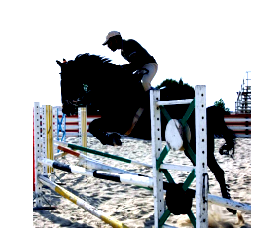

In [6]:
x, d = dataset_train[0]

y, f = dataset_val[1]

z, e = dataset_test[8]

myimshow(x)



In [7]:
class VOCDataset(data.Dataset):
  
  def __init__(self, dataset, img_size = (224, 224)):
    super(VOCDataset, self).__init__()
    self.dataset = dataset
    self.img_size = img_size
  
  def collate_fn(self, batch):
    imgs, targets = list(zip(*batch))
    # Remove empty placeholder targets
    targets = [boxes for boxes in targets if boxes is not None]
    # Add sample index to targets
    for i, boxes in enumerate(targets):
        boxes[:, 0] = i
    targets = torch.cat(targets, 0)
    imgs = torch.stack([resize(img, img_size) for img in imgs])
    return imgs, targets

  def __getitem__(self, idx):
    x, d = self.dataset[idx]
    return x, d
  def __len__(self):
    return len(self.dataset)



In [8]:
trainset = VOCDataset(dataset_train)
valset = VOCDataset(dataset_val)
testset = VOCDataset(dataset_test)

# testset = testset[1]
print(len(trainset))
print(len(valset))
print(len(testset))



5717
11540
5823


In [9]:
object_to_idx = {'aeroplane': 0,'bicycle': 1,'bird': 2,'boat': 3,
              'bottle': 4,'bus': 5,'car': 6,'cat': 7,
              'chair': 8,'cow': 9,'diningtable': 10,'dog': 11,
              'horse': 12,'motorbike': 13,'person': 14,'pottedplant': 15,
              'sheep': 16,'sofa': 17,'train': 18,'tvmonitor': 19}


class_names = list(object_to_idx.keys())
print(class_names)



['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


In [10]:
Argument_Dict = {}
Argument_Dict['epochs'] = 100
Argument_Dict['batch_size'] = 8
Argument_Dict['model_def'] = 'config/yolov3-custom.cfg'
Argument_Dict['pretrain_weights'] = 'checkpoints/yolov3_ckpt_87.pth' #train start
#59 mAP is 0.55# 71 mAP 0.56
Argument_Dict['yolov3_weights'] = 'weights/yolov3.weights'
Argument_Dict['n_cpu'] = 8
Argument_Dict['gradient_accumulations'] = 2
Argument_Dict['evaluation_interval'] = 1
Argument_Dict['checkpoint_interval'] = 1
Argument_Dict['img_size'] = 224
Argument_Dict['conf_thres'] = 0.8 #object confidence threshold
Argument_Dict['nms_thres'] = 0.4 #iou thresshold for non-maximum suppression"

print(Argument_Dict)



{'epochs': 100, 'batch_size': 8, 'model_def': 'config/yolov3-custom.cfg', 'pretrain_weights': 'checkpoints/yolov3_ckpt_87.pth', 'yolov3_weights': 'weights/yolov3.weights', 'n_cpu': 8, 'gradient_accumulations': 2, 'evaluation_interval': 1, 'checkpoint_interval': 1, 'img_size': 224, 'conf_thres': 0.8, 'nms_thres': 0.4}


In [11]:
#Test

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
os.makedirs("output", exist_ok=True)

model = Darknet(Argument_Dict['model_def'], img_size = 224).to(device)
model.load_state_dict(torch.load(Argument_Dict['pretrain_weights']))
model.eval()
# torch.save(model.state_dict(), f"weights/yolov3_custom_weights.pth")



cuda


Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

In [21]:
dataloader_test = DataLoader(
    dataset = testset,
    batch_size= 1,
    drop_last = True,
    shuffle=False,
)



loader_length = len(dataloader_test)

print(loader_length)

mini_batch = []
mini_label = []
for batch_i, (local_batch, local_label) in enumerate(dataloader_test):
    mini_batch.append(local_batch)
    mini_label.append(local_label)
    
    


5823


KeyboardInterrupt: 

In [22]:
print(mini_batch[0].shape)



torch.Size([1, 3, 224, 224])


In [25]:
Argument_Dict['plot'] = 15
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

# input_imgs, y = valset[1]
input_imgs = mini_batch[Argument_Dict['plot']]
input_imgs = Variable(input_imgs.type(Tensor))

with torch.no_grad():
    detections = model(input_imgs)
    detections = non_max_suppression(detections, Argument_Dict['conf_thres'], Argument_Dict['nms_thres'])

cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, 20)] 
detections_ori = detections[0]
print(detections)
test_img = input_imgs.cpu().resize_(3, 224, 224)



[tensor([[126.4323,  66.1089, 146.7523, 142.9897,   1.0000,   1.0000,   2.0000],
        [ 46.3112,  95.5933,  88.0082, 150.2257,   0.9981,   1.0000,   2.0000]])]


	+ Label: bird, Conf: 1.00000
tensor(45.3570)
tensor(114.2916)
tensor(282.2150)
tensor(98.2780)
	+ Label: bird, Conf: 1.00000
tensor(93.0736)
tensor(81.2169)
tensor(103.3732)
tensor(142.1097)


<Figure size 432x288 with 0 Axes>

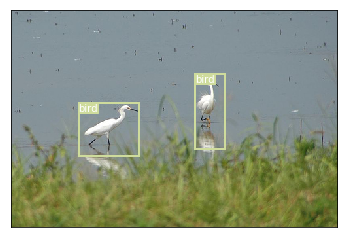

In [26]:
unique_labels = detections[0][:, -1].cpu().unique()
n_cls_preds = len(unique_labels)
bbox_colors = random.sample(colors, n_cls_preds)

img, lll = dataset_origin[Argument_Dict['plot']]
test_img_size = [np.size(img)[0], np.size(img)[1]]
im = np.array(img)
plt.figure()
fig, ax = plt.subplots(1)
ax.imshow(im)
original_shape = test_img_size
current_dim = 224
orig_w, orig_h = original_shape

for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections_ori:
    if cls_conf > Argument_Dict['nms_thres']:
        print("\t+ Label: %s, Conf: %.5f" % (class_names[int(cls_pred)], cls_conf.item()))
        x1 = x1 * orig_w / current_dim
        y1 = y1 * orig_h / current_dim
        x2 = x2 * orig_w / current_dim
        y2 = y2 * orig_h / current_dim
        box_w = x2 - x1
        box_h = y2 - y1
        print(box_w)
        print(box_h)
        print(x1)
        print(y1)

        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]

        # Create a Rectangle patch
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")


        # Add the bbox to the plot
        ax.add_patch(bbox)

        # Add label
        plt.text(
            x1,
            y1,
            s=class_names[int(cls_pred)],
            color="white",
            verticalalignment="top",
            bbox={"color": color, "pad": 0},
        )
plt.gca().xaxis.set_major_locator(NullLocator())
plt.gca().yaxis.set_major_locator(NullLocator())  
# plt.gca().invert_yaxis()
plt.show()  

